## Deep Network Regularization for Phase-base MREPT with SURE

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt

from utils.common_utils import *
from scipy.io import loadmat,savemat

import matplotlib.pyplot as plt
import random
import torch.backends.cudnn as cudnn
%matplotlib inline


import numpy as np
from models import *
from include import *
from utils.denoising_utils import *

import torch
import torch.optim


GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor


plt.rcParams["figure.figsize"] = (10, 8)

Seed = 0
random.seed(Seed)
np.random.seed(Seed)
torch.manual_seed(Seed)
torch.cuda.manual_seed(Seed)
torch.cuda.manual_seed_all(Seed)
# !nvidia-smi

num GPUs 1


In [2]:
def Crop_image(img, d=32):  
    new_size = (img.shape[0] - img.shape[0] % d, 
                img.shape[1] - img.shape[1] % d)

    img_cropped = img[
           int((img.shape[0] - new_size[0])/2):int((img.shape[0] + new_size[0])/2), 
           int((img.shape[1] - new_size[1])/2):int((img.shape[1] + new_size[1])/2)]

    
    return img_cropped

## Load Data

In [3]:
# Load data (Need the original complex data and skull-stripping mask)
data2 =loadmat('res0.5_avg1_imcmb_SNR9.2.mat')
print(data2.keys())
slice = 12
noise_data = data2['Combined_image'][:,:,slice]
mask = data2['ROI'][:,:,slice]

# Crop the data
a = Crop_image(np.real(noise_data))
b = Crop_image(np.imag(noise_data))
mask = Crop_image(mask)

# parameters for Nomarizing data
print(std := np.std(noise_data).item(), mean := np.mean([noise_data.real, noise_data.imag]).item())
# Data concatation(real&imaginary part)
ab = np.concatenate((np.expand_dims(a,axis=0)*mask,np.expand_dims(b,axis=0)*mask),axis=0)
# Calculate the background noise power for SURE loss
sigma_ = np.std(a[:30,:30])
sigma_

dict_keys(['__header__', '__version__', '__globals__', 'Combined_image', 'ROI'])
0.1404791172907435 0.07486384836509204


0.019642030166468413

## Hyperparameter tuning

In [4]:
# DIP network parameter setting
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'
PLOT= True
device=torch.device('cuda:0')

# Stochastic Temporal ensembling (STE) 
reg_noise_std =1/70
# Exponential Moving Average (EMA) 
out_avg = True
exp_weight=0.99
# Determine the accuary of SURE loss 
epsilon = 1e-3  

LR = 0.002 #Learning Rate

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
dtype = torch.cuda.FloatTensor

num_iter = 1000
input_depth = 2 
figsize = 4 

#if you want to work with 3D data, you can increase the channel number
# For different data resolutions or fields of view (FOV), 
# you need to determine the optimal number of encoder and decoder channels, as well as the number of skip connections.
n_channels=2
upsample_mode='bilinear'
downsample_mode='stride'
act_fun='LeakyReLU'
net = skip(input_depth, n_channels, num_channels_down = [256, 256, 256, 256, 256 ],
                                            num_channels_up =  [256, 256, 256, 256, 256] ,
                                            num_channels_skip = [0, 0, 6, 6, 6], 
                                            upsample_mode=upsample_mode, downsample_mode=downsample_mode,
                                            need_sigmoid=False, need_bias=True, pad=pad, act_fun=act_fun).type(dtype)

## Training network

Starting optimization with ADAM


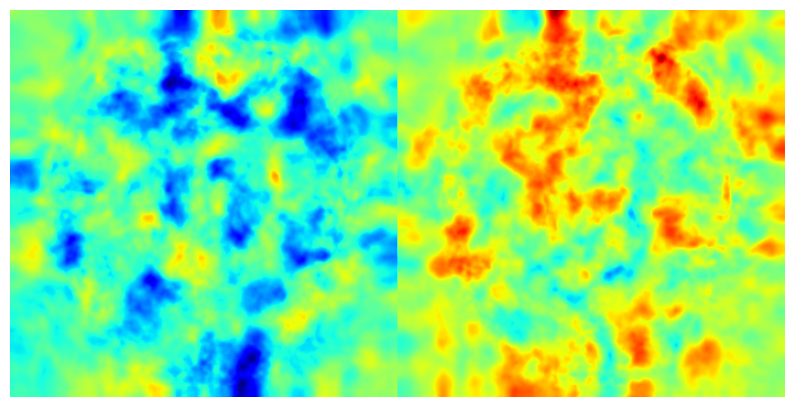

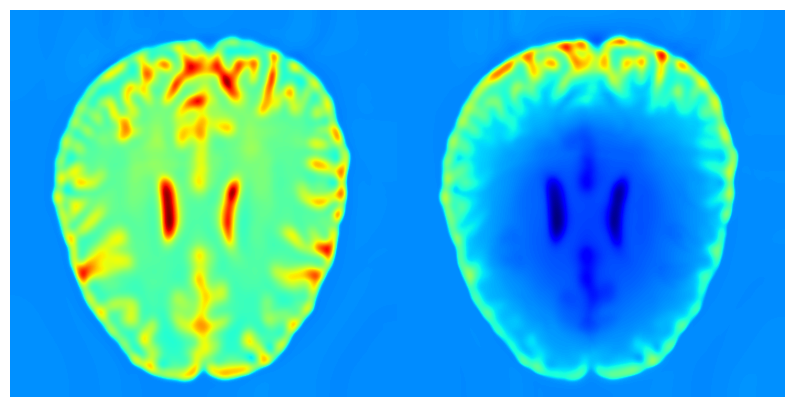

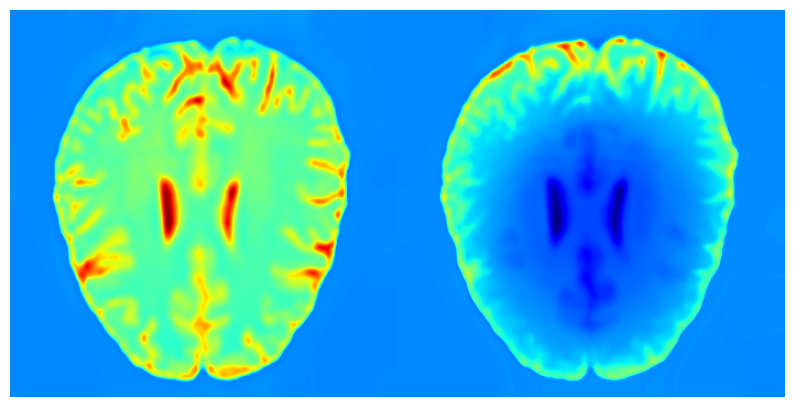

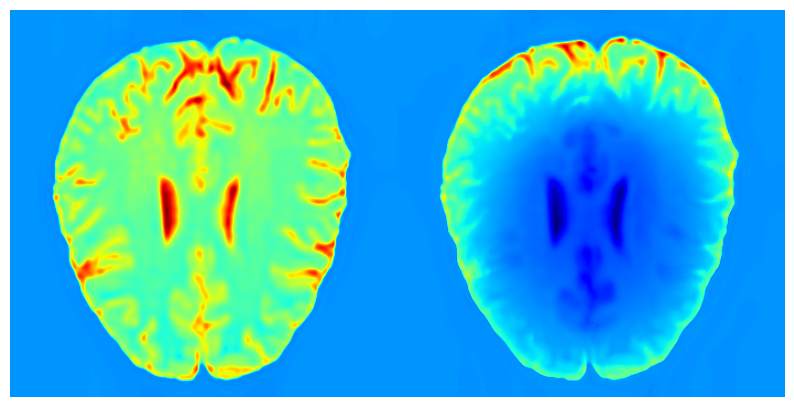

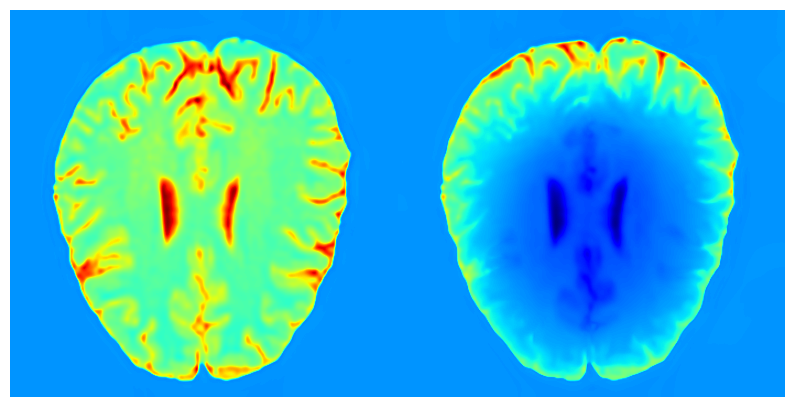

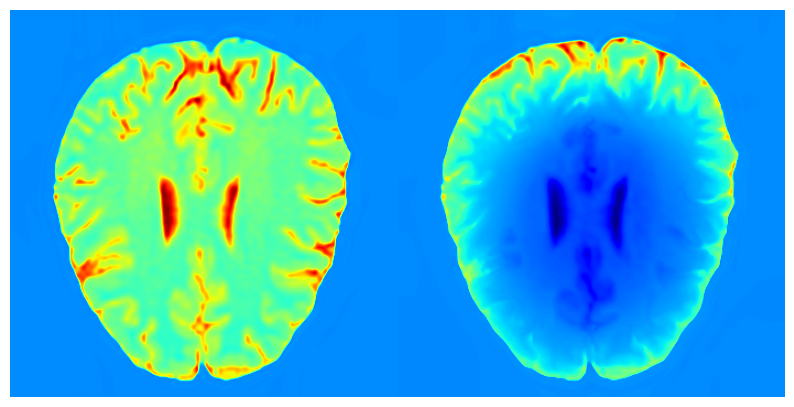

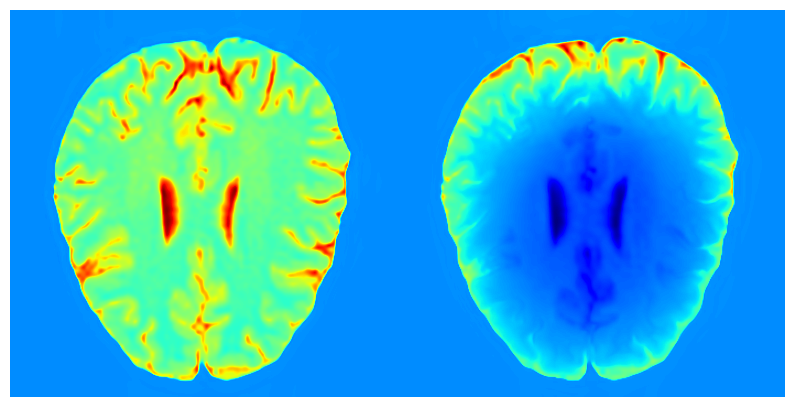

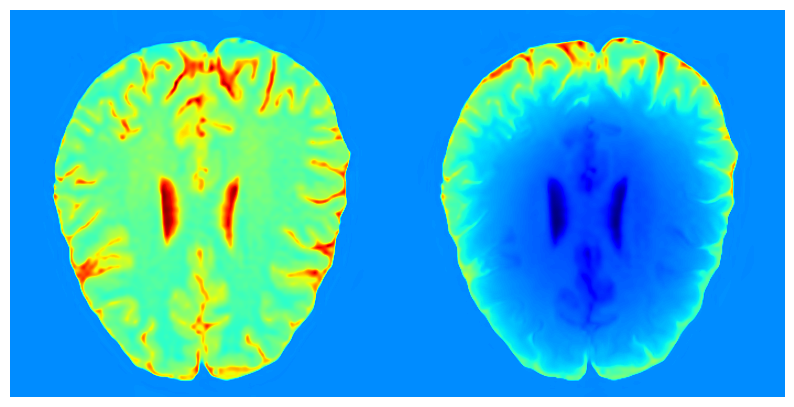

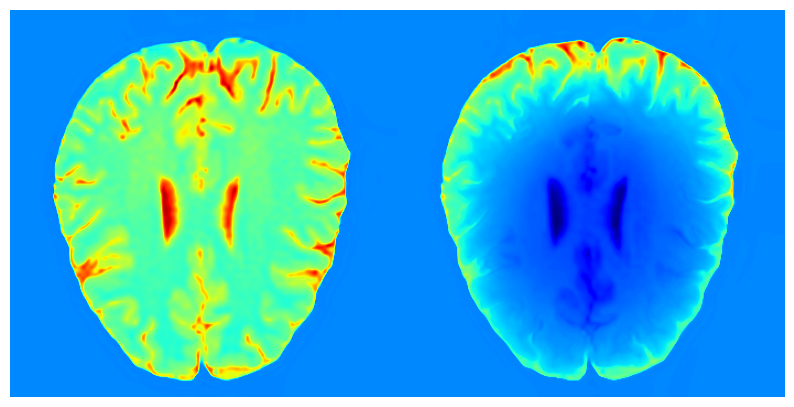

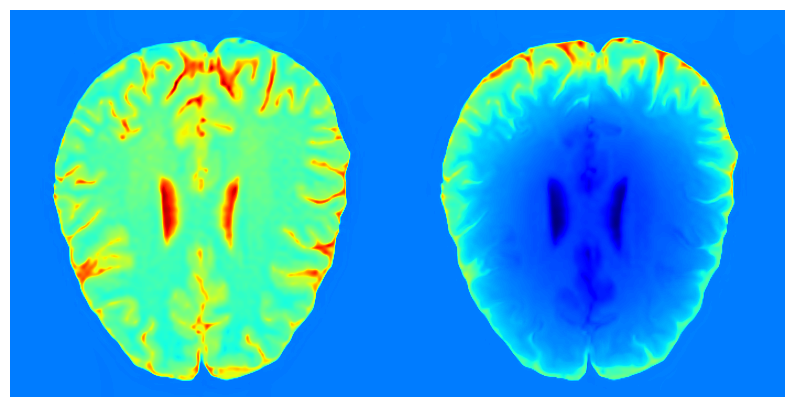

In [5]:
img_noisy_torch = np_to_torch(ab).type(dtype)
img_noisy_norm = (img_noisy_torch - mean) / std
net_input = img_noisy_norm
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
mse = torch.nn.MSELoss().type(dtype)

SURE_losses = np.zeros(num_iter)
Divergences_terms = np.zeros(num_iter)
min_loss=np.inf

i = 0
def closure():
    
    global i, out_avg, net_input
    global SURE_losses, Divergences_terms, min_loss, best_net

    
    # Stochastic Temporal Ensembling (STE) 
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input).to(device)
    
    # Exponential Moving Average (EMA) 
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)

    
    # Calculate the fidelity term of SURE Loss 
    fidelity_loss = mse(out, img_noisy_norm)
    # Calculate the divergence term of SURE Loss
    eta = torch.randn(noise.size(), device=device)
    net_input_perturbed = net_input.data.clone() + (eta * epsilon)
    dx=net(net_input_perturbed) - out
    MCdiv = torch.sum(eta * dx) / epsilon
    div_term = 2. * sigma_ ** 2 * MCdiv / ab.size
    # Calculate SURE Loss
    SURE_loss = fidelity_loss - sigma_ ** 2 + div_term



    SURE_losses[i] = SURE_loss
    Divergences_terms[i] = div_term


    if SURE_loss<min_loss:
        min_loss=SURE_loss
        best_net=copy.deepcopy(net)


    SURE_loss.backward()
        
    if  PLOT and (i % show_every == 0):
        out_np = torch_to_np(out)
        out_np = out_np * std + mean
        ab1 = np.concatenate((np.squeeze(out_np[0,:,:]),np.squeeze(out_np[1,:,:])),axis=1)
        plt.imshow(ab1)
        plt.jet()
        plt.axis('off')
        plt.show()
            
    i=i+1
    return SURE_loss.item()  
   

p = get_params(OPT_OVER, net, net_input)
loss = optimize(OPTIMIZER, p, closure, LR, num_iter)

## Acquire denoised data

In [6]:
final_result = best_net(net_input)* std + mean
Real_result =np.squeeze(torch_to_np(final_result))
DIP_Brain = np.squeeze(Real_result[0,:,:])+1j*np.squeeze(Real_result[1,:,:])

(-0.5, 351.5, 351.5, -0.5)

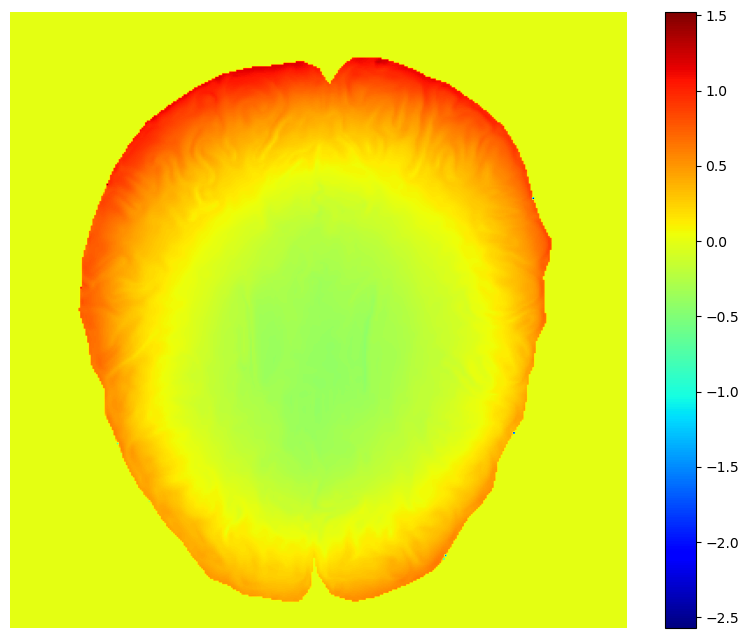

In [7]:
plt.imshow(np.angle(DIP_Brain)*mask)
plt.jet()
plt.colorbar()
plt.axis('off')

(-0.5, 703.5, 351.5, -0.5)

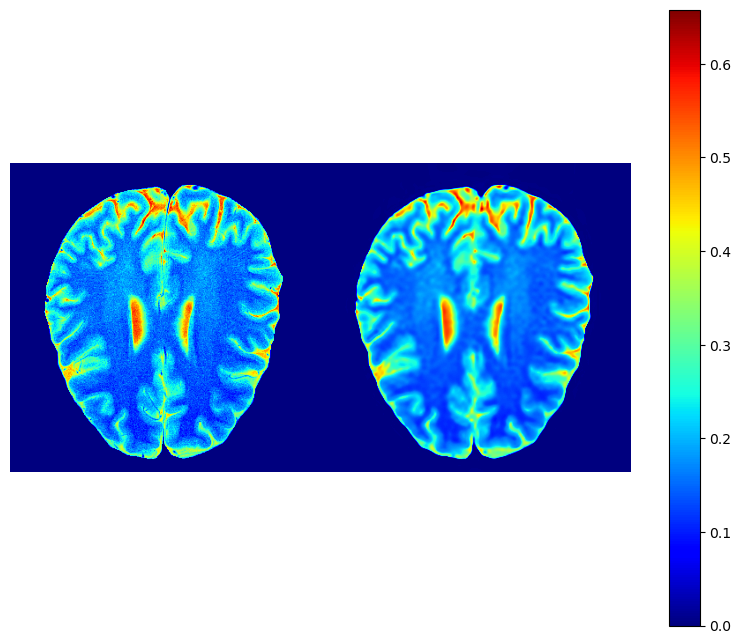

In [8]:
noise_data1 = Crop_image(noise_data)*mask
Real_result1 = np.concatenate((np.abs(noise_data1),np.abs(DIP_Brain)),axis=1)
plt.imshow(Real_result1)
plt.jet()
plt.colorbar()
plt.axis('off')

## Data Save

In [9]:
# savemat('DIP-SURE_denosing_brain.mat',{'DIP_SURE':DIP_Brain,'mask':mask})